In [1]:
import earthaccess

earthaccess.login(strategy="netrc")
print("Authenticated")


c:\UNESCO\Code\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Authenticated


In [15]:
SHORT_NAME = "SWOT_L4_HR_DAWG_SOS_DISCHARGE_V3"

granules = earthaccess.search_data(
    short_name=SHORT_NAME,
    sort_key="-start_date",
    count=1
)

print("Granules found:", len(granules))

paths = earthaccess.download(
    granules,
    local_path="./downloaded_files"
)

print(paths[0])



Granules found: 1


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<?, ?it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:37<00:00, 97.73s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<?, ?it/s]

downloaded_files\oc_sword_v16_SOS_results_unconstrained_20230502T204408_20250502T204408_20251219T163700.nc


In [30]:
import earthaccess

earthaccess.login(strategy="netrc")

SHORT_NAME = "SWOT_L4_HR_DAWG_SOS_DISCHARGE_V3"

granules = earthaccess.search_data(
    short_name=SHORT_NAME,
    count=50  # enough to list all regions
)

print(f"Found {len(granules)} granules")
for g in granules:
    print(g["meta"]["native-id"])


Found 6 granules
na_sword_v16_SOS_results_unconstrained_20230502T204408_20250502T204408_20251219T163700
af_sword_v16_SOS_results_unconstrained_20230502T204408_20250502T204408_20251219T163700
eu_sword_v16_SOS_results_unconstrained_20230502T204408_20250502T204408_20251219T163700
sa_sword_v16_SOS_results_unconstrained_20230502T204408_20250502T204408_20251219T163700
as_sword_v16_SOS_results_unconstrained_20230502T204408_20250502T204408_20251219T163700
oc_sword_v16_SOS_results_unconstrained_20230502T204408_20250502T204408_20251219T163700


In [31]:
eu_granules = [
    g for g in granules
    if g["meta"]["native-id"].startswith("eu_")
]

for g in eu_granules:
    print(g["meta"]["native-id"])


eu_sword_v16_SOS_results_unconstrained_20230502T204408_20250502T204408_20251219T163700


In [32]:
paths = earthaccess.download(
    eu_granules,
    local_path="./downloaded_files/sos_europe"
)

paths


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1001.74it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [04:04<00:00, 244.42s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<?, ?it/s]


[WindowsPath('downloaded_files/sos_europe/eu_sword_v16_SOS_results_unconstrained_20230502T204408_20250502T204408_20251219T163700.nc')]

In [10]:
import netCDF4 as nc
import numpy as np

NC_PATH = r"downloaded_files\sos_europe\eu_sword_v16_SOS_results_unconstrained_20230502T204408_20250502T204408_20251219T163700.nc"

ds = nc.Dataset(NC_PATH)
reaches = ds.groups["reaches"]
print("Reach vars:", list(reaches.variables.keys()))

reach_ids = reaches.variables["reach_id"][:]
print("Num reaches:", reach_ids.size)
print("Min/Max reach_id:", int(reach_ids.min()), int(reach_ids.max()))
print("First 10 reach_ids:", reach_ids[:10])
ds.close()


OSError: [Errno -101] NetCDF: HDF error: 'downloaded_files\\sos_europe\\eu_sword_v16_SOS_results_unconstrained_20230502T204408_20250502T204408_20251219T163700.nc'

In [28]:
import matplotlib.pyplot as plt 
import netCDF4 as nc 
import numpy as np 
 
# Open SoS results file for Europe 
sos_results = nc.Dataset(NC_PATH, "r") 
 
# Retrieve /reaches and /metroman (stage1) groups 
reaches_group = sos_results.groups["reaches"] 
metroman_group = sos_results.groups["metroman"] 
 
# Retrieve index of the considered reach 
reach_index = int(np.ravel(np.argwhere(reaches_group.variables["reach_id"][:] == 51111100013))[0]) 
 
# Retrieve datetimes 
times = reaches_group.variables["time"][reach_index][:] 
valid_times = times > -99999999999.0 
datetimes = np.array([np.datetime64("2000-01-01") + np.timedelta64(int(dt), "s") for dt in times[valid_times]]) 
 
# Retrieve MetroMan discharge results 
Q_metroman = metroman_group.variables["allq"][reach_index][:] 
Q_metroman[Q_metroman == metroman_group.variables["allq"].missing_value] = np.nan 
Q_metroman[Q_metroman <= -99999999999.0] = np.nan 

In [25]:
sos_results.groups["reaches"]

<class 'netCDF4.Group'>
group /reaches:
    dimensions(sizes): 
    variables(dimensions): int64 reach_id(num_reaches), float64 x(num_reaches), float64 y(num_reaches), <class 'str'> river_name(num_reaches), <class 'str'> observations(num_reaches), float64 time(num_reaches)
    groups: 

In [22]:
import netCDF4 as nc
import numpy as np

NC_PATH = r"C:\UNESCO\Code\downloaded_files\sos_europe\eu_sword_v16_SOS_results_unconstrained_20230502T204408_20250502T204408_20251219T163700.nc"

# Choose algorithm/variable (start with MetroMan)
ALG = "metroman"
VAR = "allq"   # per PO.DAAC cookbook

ds = nc.Dataset(NC_PATH, "r")

results = ds  # cookbook uses `results`; here ds is the results file
q = results.groups[ALG].variables[VAR][:]  # shape: (n_reaches, n_obs)
missing = results.groups[ALG].variables[VAR].missing_value

data_indexes = []
for i in range(q.shape[0]):
    row = q[i]
    if row.size > 1:
        if np.any(row != missing):
            data_indexes.append(i)
    else:
        if row != missing:
            data_indexes.append(i)

print("10 indexes with discharge data:", data_indexes[:10])

reach_ids = results.groups["reaches"].variables["reach_id"][data_indexes]
river_names = results.groups["reaches"].variables["river_name"][data_indexes]

print("10 reach_ids with discharge:", reach_ids[:10])
print("10 river_names:", river_names[:10])

ds.close()


10 indexes with discharge data: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
10 reach_ids with discharge: [21101200013 21101200033 21101200041 21101200053 21101200063 21101200075
 21101300085 21101200095 21101200105 21101200115]
10 river_names: ['NODATA' 'NODATA' 'NODATA' 'NODATA' 'NODATA' 'NODATA' 'NODATA' 'NODATA'
 'NODATA' 'NODATA']


In [16]:
NC_PATH = r"C:\UNESCO\Code\downloaded_files\sos_europe\eu_sword_v16_SOS_results_unconstrained_20230502T204408_20250502T204408_20251219T163700.nc"

ALG = "metroman"
VAR = "allq"

ds = nc.Dataset(NC_PATH, "r")
q = ds.groups[ALG].variables[VAR][:]               # (n_reaches, n_times)
missing = ds.groups[ALG].variables[VAR].missing_value

has_data = []
for i in range(q.shape[0]):
    row = q[i]
    # valid if ANY value is not missing
    if np.any(row != missing):
        has_data.append(True)
    else:
        has_data.append(False)

has_data = np.array(has_data, dtype=bool)

n_total = q.shape[0]
n_with = int(has_data.sum())
n_without = int((~has_data).sum())

print(f"{ALG}/{VAR}")
print("Total reaches:      ", n_total)
print("With discharge:     ", n_with)
print("Without discharge:  ", n_without)
print("Percent without:    ", round(100 * n_without / n_total, 1), "%")

ds.close()

metroman/allq
Total reaches:       30363
With discharge:      30363
Without discharge:   0
Percent without:     0.0 %


In [3]:
import netCDF4 as nc
import numpy as np

NC_PATH = r"C:\UNESCO\Code\downloaded_files\sos_europe\eu_sword_v16_SOS_results_unconstrained_20230502T204408_20250502T204408_20251219T163700.nc"

ALG = "metroman"
VAR = "allq"
MIN_VALID_POINTS = 3  # set to 1 if you truly mean "any single valid value"

ds = nc.Dataset(NC_PATH, "r")

q = ds.groups[ALG].variables[VAR][:]
missing = ds.groups[ALG].variables[VAR].missing_value

# Scalarize missing if it's array-like
if np.ndim(missing) > 0:
    missing = np.array(missing).ravel()[0]

data_indexes = []
valid_counts = []

for i in range(q.shape[0]):
    row = q[i].astype(float)

    valid = (
        (row != missing) &
        (row > -9.0e10) &
        np.isfinite(row)
    )

    n_valid = int(np.sum(valid))
    if n_valid >= MIN_VALID_POINTS:
        data_indexes.append(i)
        valid_counts.append(n_valid)

print("Num reaches with >= MIN_VALID_POINTS valid discharge:", len(data_indexes))
print("First 10 indexes:", data_indexes[:10])
print("First 10 valid counts:", valid_counts[:10])

reach_ids = ds.groups["reaches"].variables["reach_id"][data_indexes]
river_names = ds.groups["reaches"].variables["river_name"][data_indexes]

print("First 10 reach_ids:", reach_ids[:10])
print("First 10 river_names:", river_names[:10])

ds.close()


Num reaches with >= MIN_VALID_POINTS valid discharge: 7725
First 10 indexes: [2, 23, 29, 30, 31, 32, 33, 34, 35, 36]
First 10 valid counts: [41, 11, 10, 10, 5, 9, 11, 11, 12, 12]
First 10 reach_ids: [21101200041 21101800061 21103200021 21103200031 21103200041 21103200051
 21103200061 21103200071 21103200081 21103200091]
First 10 river_names: ['NODATA' 'Asi Nehri' 'Ceyhan' 'Ceyhan' 'Ceyhan' 'Ceyhan' 'Ceyhan'
 'Ceyhan' 'Ceyhan' 'Ceyhan']


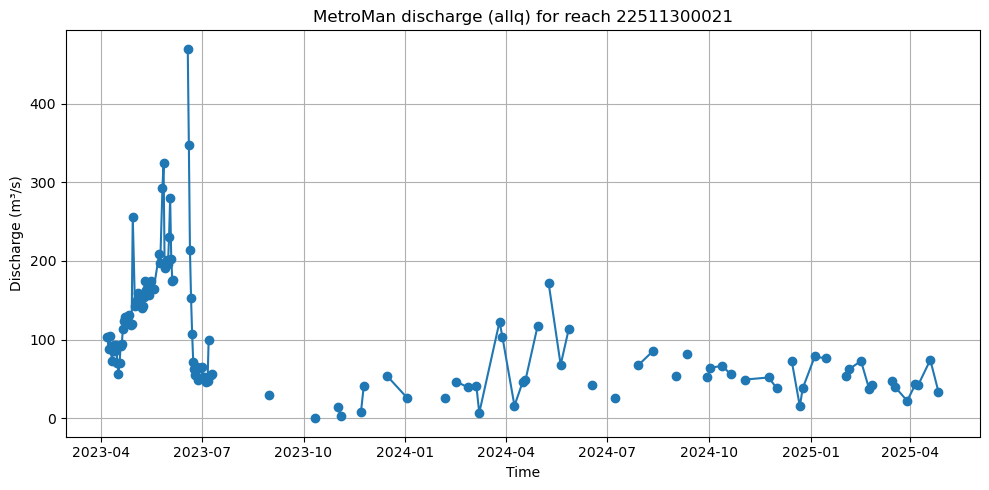

In [10]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np

REACH_ID = int(22511300021)  # replace with a reach_id you printed above

ds = nc.Dataset(NC_PATH, "r")
reaches = ds.groups["reaches"]

# time for this reach
reach_ids = reaches.variables["reach_id"][:]
idx = np.where(reach_ids == REACH_ID)[0]
if idx.size == 0:
    ds.close()
    raise ValueError(f"Reach {REACH_ID} not found in this file.")

i = int(idx[0])
times = reaches.variables["time"][i][:]
valid_time = times > -9.0e10
times_valid = times[valid_time]

datetimes = np.array([
    np.datetime64("2000-01-01") + np.timedelta64(int(t), "s")
    for t in times_valid
])

# MetroMan discharge
metroman = ds.groups["metroman"].variables["allq"]
q = metroman[i][valid_time].astype("float64")
missing = metroman.missing_value
q[(q == missing) | (q <= -9.0e10)] = np.nan

plt.figure(figsize=(10,5))
plt.plot(datetimes, q, marker="o")
plt.title(f"MetroMan discharge (allq) for reach {REACH_ID}")
plt.xlabel("Time")
plt.ylabel("Discharge (m³/s)")
plt.grid(True)
plt.tight_layout()
plt.show()

ds.close()


In [1]:
import geopandas as gpd

GPKG_PATH = r"C:\UNESCO\Code\data\Dnipro_basin_shapefiles\clipped_SWORD\dnipro_sword_reaches_clip.gpkg"

# List layers (some gpkg have multiple)
layers = gpd.list_layers(GPKG_PATH)
print(layers)

# Read the first layer by default
layer_name = layers.iloc[0]["name"]
gdf = gpd.read_file(GPKG_PATH, layer=layer_name)

print("Rows:", len(gdf))
print("CRS:", gdf.crs)
print("Columns:", list(gdf.columns))
gdf.head()


             name geometry_type
0  dnipro_reaches    LineString
Rows: 842
CRS: EPSG:4326
Columns: ['x', 'y', 'reach_id', 'reach_len', 'n_nodes', 'wse', 'wse_var', 'width', 'width_var', 'facc', 'n_chan_max', 'n_chan_mod', 'obstr_type', 'grod_id', 'hfalls_id', 'slope', 'dist_out', 'lakeflag', 'max_width', 'n_rch_up', 'n_rch_dn', 'rch_id_up', 'rch_id_dn', 'swot_orbit', 'swot_obs', 'type', 'river_name', 'edit_flag', 'trib_flag', 'path_freq', 'path_order', 'path_segs', 'main_side', 'strm_order', 'end_reach', 'network', 'geometry']


,x,y,reach_id,reach_len,n_nodes,wse,wse_var,width,width_var,facc,...,edit_flag,trib_flag,path_freq,path_order,path_segs,main_side,strm_order,end_reach,network,geometry
0,33.542051,46.838603,22511300103,10517.863872,53,12.1,0.000000,4351.000000,164507.685706,488511.708554,...,NaN,0,39,262,200,0,5,0,2,"LINESTRING (33.47593 46.83353, 33.47632 46.833..."
1,32.361843,46.521577,22400900035,15336.123108,77,0.0,0.000867,426.500000,47086.428518,129.298721,...,NaN,0,-9999,-9999,944,1,-9999,3,2,"LINESTRING (32.37496 46.52541, 32.37526 46.525..."
2,32.369500,46.550351,22601000045,12699.288888,63,0.0,3.821328,278.163208,39592.084131,88.218163,...,NaN,0,41,262,201,0,5,3,2,"LINESTRING (32.38201 46.54688, 32.38202 46.546..."
3,32.530941,46.593655,22511100015,15609.133468,78,0.7,0.238765,225.000000,26398.122526,510466.468750,...,NaN,1,41,262,201,0,5,3,2,"LINESTRING (32.44571 46.55942, 32.44611 46.559..."
4,32.724987,46.633470,22511100055,18748.992721,94,1.4,0.001881,105.000000,5196.643614,219.899963,...,NaN,1,-9999,-9999,998,1,-9999,3,2,"LINESTRING (32.61399 46.6187, 32.61478 46.6176..."


In [7]:
import netCDF4 as nc
import numpy as np
import pandas as pd

NC_PATH = r"downloaded_files\oc_sword_v16_SOS_results_unconstrained_20230502T204408_20250502T204408_20251219T163700.nc"

ALG = "metroman"
VAR = "allq"
MIN_VALID_POINTS = 3  # set to 1 if you truly mean any single measurement

ds = nc.Dataset(NC_PATH, "r")

q = ds.groups[ALG].variables[VAR][:]
missing = ds.groups[ALG].variables[VAR].missing_value

# Scalarize missing if it's array-like
if np.ndim(missing) > 0:
    missing = np.array(missing).ravel()[0]

reach_ids_all = ds.groups["reaches"].variables["reach_id"][:]
river_names_all = ds.groups["reaches"].variables["river_name"][:]

records = []

for i in range(q.shape[0]):
    rid = int(reach_ids_all[i])

    # only consider Dnipro basin reaches
    if rid not in dnipro_reach_set:
        continue

    row = q[i].astype(float)

    valid = (
        (row != missing) &
        (row > -9.0e10) &
        np.isfinite(row)
    )

    n_valid = int(np.sum(valid))

    if n_valid >= MIN_VALID_POINTS:
        records.append({
            "reach_id": rid,
            "river_name": river_names_all[i],
            "n_valid_obs": n_valid
        })

ds.close()

df = pd.DataFrame(records)
print(f"Dnipro reaches with >= {MIN_VALID_POINTS} valid obs:", len(df))
df.sort_values("n_valid_obs", ascending=False).head(10)


NameError: name 'dnipro_reach_set' is not defined

In [1]:
2+2

4

In [8]:
import netCDF4 as nc
import numpy as np
import pandas as pd

NC_PATH = r"downloaded_files\oc_sword_v16_SOS_results_unconstrained_20230502T204408_20250502T204408_20251219T163700.nc"

# --- Consensus settings ---
ALG = "consensus"
VAR = "consensus_q"
MIN_VALID_POINTS = 3  # set to 1 if you truly mean any single measurement

ds = nc.Dataset(NC_PATH, "r")

# consensus_q is typically (num_reaches, num_times)
q = ds.groups[ALG].variables[VAR][:]

# Consensus missing handling:
# Prefer _FillValue if present, else missing_value if present.
var_obj = ds.groups[ALG].variables[VAR]
missing = None
if "_FillValue" in var_obj.ncattrs():
    missing = var_obj.getncattr("_FillValue")
elif "missing_value" in var_obj.ncattrs():
    missing = var_obj.getncattr("missing_value")

# Scalarize missing if it's array-like
if missing is not None and np.ndim(missing) > 0:
    missing = np.array(missing).ravel()[0]

reach_ids_all = ds.groups["reaches"].variables["reach_id"][:]
river_names_all = ds.groups["reaches"].variables["river_name"][:]

records = []

for i in range(q.shape[0]):
    rid = int(reach_ids_all[i])

    # only consider Dnipro basin reaches
    if rid not in dnipro_reach_set:
        continue

    row = q[i].astype(float)

    valid = np.isfinite(row) & (row > -9.0e10)
    if missing is not None:
        valid = valid & (row != missing)

    n_valid = int(np.sum(valid))

    if n_valid >= MIN_VALID_POINTS:
        records.append({
            "reach_id": rid,
            "river_name": river_names_all[i],
            "n_valid_obs": n_valid
        })

ds.close()

df = pd.DataFrame(records)
print(f"Dnipro reaches with >= {MIN_VALID_POINTS} valid consensus obs:", len(df))

if len(df) == 0:
    df
else:
    df.sort_values("n_valid_obs", ascending=False).head(10)


NameError: name 'dnipro_reach_set' is not defined

In [28]:
df_top10 = df.sort_values("n_valid_obs", ascending=False).head(10)
df_top10


,reach_id,river_name,n_valid_obs
67,22520400261,Seym River,161
13,22511200341,Inhulets,159
15,22511300031,NODATA,148
14,22511300021,Dnipro,143
16,22511300071,Inhulets,139
10,22511200161,Inhulets,136
68,22520400271,Seym River,131
62,22520400181,Seym River,130
12,22511200291,Inhulets,130
8,22511200091,Inhulets,127


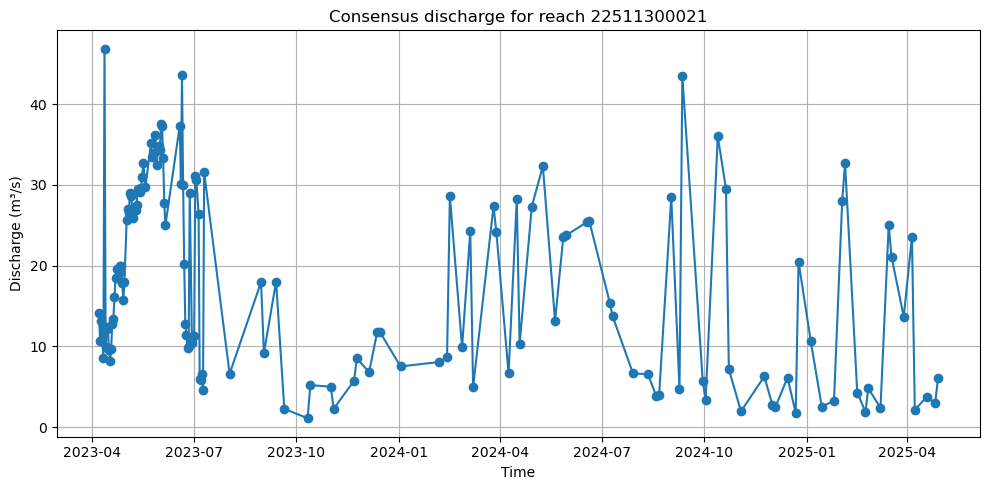

In [3]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np

NC_PATH = r"C:\UNESCO\Code\downloaded_files\sos_europe\eu_sword_v16_SOS_results_unconstrained_20230502T204408_20250502T204408_20251219T163700.nc"
REACH_ID = 22511300021  # must be one of your valid consensus reaches

ds = nc.Dataset(NC_PATH, "r")

reaches = ds.groups["reaches"]
consensus = ds.groups["consensus"]

# --- find reach index ---
reach_ids = reaches.variables["reach_id"][:].astype("int64")
idx = np.where(reach_ids == REACH_ID)[0]
if idx.size == 0:
    ds.close()
    raise ValueError(f"Reach {REACH_ID} not found in file.")

i = int(idx[0])

# --- time for this reach (vlen) ---
time_var = consensus.variables["time_int"]
times = np.asarray(time_var[i], dtype="float64")

valid_time = times > -9.0e10
times_valid = times[valid_time].astype("int64")

datetimes = np.array([
    np.datetime64("2000-01-01") + np.timedelta64(int(t), "s")
    for t in times_valid
])

# --- consensus discharge for this reach (vlen) ---
qvar = consensus.variables["consensus_q"]
q = np.asarray(qvar[i], dtype="float64")[valid_time]

# missing handling
missing = None
if "_FillValue" in qvar.ncattrs():
    missing = qvar.getncattr("_FillValue")
elif "missing_value" in qvar.ncattrs():
    missing = qvar.getncattr("missing_value")

if missing is not None:
    q[q == missing] = np.nan

q[q <= -9.0e10] = np.nan

# --- plot ---
plt.figure(figsize=(10, 5))
plt.plot(datetimes, q, marker="o")
plt.title(f"Consensus discharge for reach {REACH_ID}")
plt.xlabel("Time")
plt.ylabel("Discharge (m³/s)")
plt.grid(True)
plt.tight_layout()
plt.show()

ds.close()


In [1]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import geopandas as gpd

# ---- Inputs ----
NC_PATH = r"C:\UNESCO\Code\downloaded_files\sos_europe\eu_sword_v16_SOS_results_unconstrained_20230502T204408_20250502T204408_20251219T163700.nc"
SWORD_GPKG = r"C:\UNESCO\Code\data\Dnipro_basin_shapefiles\clipped_SWORD\dnipro_sword_reaches_clip.gpkg"

REACH_ID = 22511300021  # choose one of your valid consensus reaches
OUT_CSV = rf"C:\UNESCO\Code\outputs\reach_{REACH_ID}_consensus_timeseries.csv"

# ---- 1) Load SWORD geometry for this reach_id ----
gdf = gpd.read_file(SWORD_GPKG)

# If your reach id field name differs, change it here:
SWORD_REACH_COL = "reach_id"

# Ensure integer comparison
gdf[SWORD_REACH_COL] = pd.to_numeric(gdf[SWORD_REACH_COL], errors="coerce").astype("Int64")

row_g = gdf.loc[gdf[SWORD_REACH_COL] == REACH_ID].copy()
if row_g.empty:
    raise ValueError(f"Reach {REACH_ID} not found in SWORD GPKG: {SWORD_GPKG}")

geom_wkt = row_g.geometry.iloc[0].wkt

# ---- 2) Pull consensus time series from the SOS NetCDF ----
ds = nc.Dataset(NC_PATH, "r")

reaches = ds.groups["reaches"]
consensus = ds.groups["consensus"]

reach_ids = reaches.variables["reach_id"][:].astype("int64")
idx = np.where(reach_ids == REACH_ID)[0]
if idx.size == 0:
    ds.close()
    raise ValueError(f"Reach {REACH_ID} not found in SOS NetCDF: {NC_PATH}")

i = int(idx[0])

# vlen per reach
t_var = consensus.variables["time_int"]
q_var = consensus.variables["consensus_q"]

times = np.asarray(t_var[i], dtype="float64")
q = np.asarray(q_var[i], dtype="float64")

# Missing handling
missing = None
if "_FillValue" in q_var.ncattrs():
    missing = q_var.getncattr("_FillValue")
elif "missing_value" in q_var.ncattrs():
    missing = q_var.getncattr("missing_value")
if missing is not None and np.ndim(missing) > 0:
    missing = np.array(missing).ravel()[0]

# Valid mask
valid = np.isfinite(times) & (times > -9.0e10) & np.isfinite(q) & (q > -9.0e10)
if missing is not None:
    valid = valid & (q != missing)

times_valid = times[valid].astype("int64")
q_valid = q[valid]

ds.close()

# ---- 3) Build dataframe + datetime ----
datetimes = pd.to_datetime("2000-01-01") + pd.to_timedelta(times_valid, unit="s")

df = pd.DataFrame({
    "reach_id": REACH_ID,
    "datetime_utc": datetimes,
    "discharge_m3s": q_valid,
    "geometry_wkt": geom_wkt,
})

# optional: sort & reset
df = df.sort_values("datetime_utc").reset_index(drop=True)

# ---- 4) Write CSV ----
df.to_csv(OUT_CSV, index=False)
print("Saved:", OUT_CSV)
print("Rows:", len(df))
df.head()


Saved: C:\UNESCO\Code\outputs\reach_22511300021_consensus_timeseries.csv
Rows: 143


,reach_id,datetime_utc,discharge_m3s,geometry_wkt
0,22511300021,2023-04-06 21:16:47,14.080940,LINESTRING (32.86650886381605 46.7021532649096...
1,22511300021,2023-04-07 21:07:26,10.698391,LINESTRING (32.86650886381605 46.7021532649096...
2,22511300021,2023-04-08 20:58:04,13.128808,LINESTRING (32.86650886381605 46.7021532649096...
3,22511300021,2023-04-09 20:48:42,10.811970,LINESTRING (32.86650886381605 46.7021532649096...
4,22511300021,2023-04-10 20:39:20,8.556153,LINESTRING (32.86650886381605 46.7021532649096...


In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import geopandas as gpd

# ---- Inputs ----
NC_PATH = r"C:\UNESCO\Code\downloaded_files\sos_europe\eu_sword_v16_SOS_results_unconstrained_20230502T204408_20250502T204408_20251219T163700.nc"
SWORD_GPKG = r"C:\UNESCO\Code\data\Dnipro_basin_shapefiles\clipped_SWORD\dnipro_sword_reaches_clip.gpkg"
OUT_CSV = r"C:\UNESCO\Code\outputs\dnipro_consensus_timeseries.csv"

SWORD_REACH_COL = "reach_id"  # change if needed

# ---- 1) Load SWORD reaches + geometry (clipped basin) ----
gdf = gpd.read_file(SWORD_GPKG)

# ensure reach_id numeric/int
gdf[SWORD_REACH_COL] = pd.to_numeric(gdf[SWORD_REACH_COL], errors="coerce")
gdf = gdf.dropna(subset=[SWORD_REACH_COL]).copy()
gdf[SWORD_REACH_COL] = gdf[SWORD_REACH_COL].astype("int64")

# build reach_id -> geometry_wkt lookup
geom_map = dict(zip(gdf[SWORD_REACH_COL].values, gdf.geometry.apply(lambda g: g.wkt).values))

dnipro_reach_ids = set(geom_map.keys())
print("Dnipro clipped SWORD reaches:", len(dnipro_reach_ids))

# ---- 2) Open SOS NetCDF (consensus) ----
ds = nc.Dataset(NC_PATH, "r")
reaches = ds.groups["reaches"]
consensus = ds.groups["consensus"]

reach_ids_nc = reaches.variables["reach_id"][:].astype("int64")

t_var = consensus.variables["time_int"]      # vlen per reach
q_var = consensus.variables["consensus_q"]   # vlen per reach

# missing handling
missing = None
if "_FillValue" in q_var.ncattrs():
    missing = q_var.getncattr("_FillValue")
elif "missing_value" in q_var.ncattrs():
    missing = q_var.getncattr("missing_value")
if missing is not None and np.ndim(missing) > 0:
    missing = np.array(missing).ravel()[0]

SENTINEL = -9.0e10

# ---- 3) Iterate reaches, export records ----
records = []
n_seen = 0
n_with_any = 0

for i in range(reach_ids_nc.shape[0]):
    rid = int(reach_ids_nc[i])

    # only keep Dnipro clipped basin
    if rid not in dnipro_reach_ids:
        continue

    n_seen += 1

    # vlen arrays for this reach
    times = np.asarray(t_var[i], dtype="float64")
    q = np.asarray(q_var[i], dtype="float64")

    # valid mask
    valid = np.isfinite(times) & (times > SENTINEL) & np.isfinite(q) & (q > SENTINEL)
    if missing is not None:
        valid = valid & (q != missing)

    if not np.any(valid):
        continue

    n_with_any += 1

    times_valid = times[valid].astype("int64")
    q_valid = q[valid].astype("float64")

    # convert to datetime (UTC)
    datetimes = pd.to_datetime("2000-01-01") + pd.to_timedelta(times_valid, unit="s")

    geom_wkt = geom_map[rid]

    # append rows (one per observation)
    records.extend(
        {
            "reach_id": rid,
            "datetime_utc": dt,
            "discharge_m3s": float(val),
            "geometry_wkt": geom_wkt,
        }
        for dt, val in zip(datetimes, q_valid)
    )

ds.close()

print("Dnipro reaches found in NetCDF:", n_seen)
print("Dnipro reaches with any valid consensus:", n_with_any)
print("Total rows (reach-time obs):", len(records))

# ---- 4) Write CSV ----
df = pd.DataFrame.from_records(records)
df = df.sort_values(["reach_id", "datetime_utc"]).reset_index(drop=True)

df.to_csv(OUT_CSV, index=False)
print("Saved:", OUT_CSV)

df.head()


Dnipro clipped SWORD reaches: 842
Dnipro reaches found in NetCDF: 559
Dnipro reaches with any valid consensus: 222
Total rows (reach-time obs): 13091
Saved: C:\UNESCO\Code\outputs\dnipro_consensus_timeseries.csv


,reach_id,datetime_utc,discharge_m3s,geometry_wkt
0,22511200011,2023-04-06 21:16:47,19.013615,LINESTRING (32.82846396290365 46.6956231045644...
1,22511200011,2023-04-07 21:07:26,15.271956,LINESTRING (32.82846396290365 46.6956231045644...
2,22511200011,2023-04-08 20:58:04,16.087600,LINESTRING (32.82846396290365 46.6956231045644...
3,22511200011,2023-04-09 20:48:42,10.556364,LINESTRING (32.82846396290365 46.6956231045644...
4,22511200011,2023-04-10 20:39:20,11.367688,LINESTRING (32.82846396290365 46.6956231045644...
